In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import re
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import load_model
import h5py

Using TensorFlow backend.


## Load the dataset

In [2]:
'''
with open('reviews_Video_Games_5.json', 'rb') as f:
    data = f.readlines()
    
data = map(lambda x: x.rstrip(), data)

data_json_str = "[" + ','.join(data) + "]"

df_t = pd.read_json(data_json_str)

df_t.loc[:,['overall','reviewText']].rename(index=str, columns={"overall": "rating", "reviewText": "text"}).to_json('Amazon_Reviews.json')
'''

'\nwith open(\'reviews_Video_Games_5.json\', \'rb\') as f:\n    data = f.readlines()\n    \ndata = map(lambda x: x.rstrip(), data)\n\ndata_json_str = "[" + \',\'.join(data) + "]"\n\ndf_t = pd.read_json(data_json_str)\n\ndf_t.loc[:,[\'overall\',\'reviewText\']].rename(index=str, columns={"overall": "rating", "reviewText": "text"}).to_json(\'Amazon_Reviews.json\')\n'

In [3]:
df = pd.read_json('Amazon_Reviews.json')

## Explore the data set

In [4]:
df.head()

,rating,text
0,1,Installing the game was a struggle (because of...
1,4,If you like rally cars get this game you will ...
10,5,I'm not quite finished with the game's DiRT To...
100,3,They work fine but i feel like they have a lit...
1000,5,This game in my opinion is the best of all the...


In [5]:
df.shape

(231780, 2)

In [6]:
df.describe()

,rating
count,231780.000000
mean,4.086397
std,1.202330
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
df['rating'].value_counts()#(normalize=True)

5    120185
4     54804
3     28275
1     14853
2     13663
Name: rating, dtype: int64

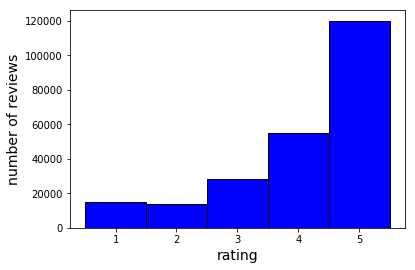

In [8]:
plt.hist(df['rating'], bins = [0.5,1.5,2.5,3.5,4.5,5.5], color = 'blue', ec='black')
plt.xlabel('rating',fontsize=14)
plt.ylabel('number of reviews',fontsize=14)
plt.xticks([1,2,3,4,5])
plt.show()

## Select only ratings = 1,3,5 uniformly

In [9]:
data = df[df['rating'].isin([1,3,5])].groupby('rating').apply(lambda s: s.sample(10000)).reset_index(drop=True)

In [10]:
data['rating']=data['rating'].map({1:0,3:1,5:2})

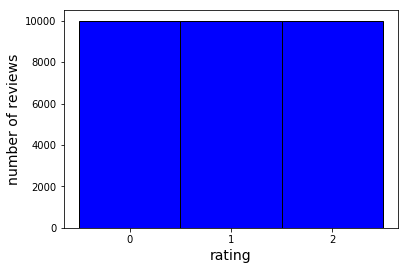

In [11]:
plt.hist(data['rating'], bins =[-0.5,0.5,1.5,2.5], color = 'blue', ec='black')
plt.xlabel('rating',fontsize=14)
plt.ylabel('number of reviews',fontsize=14)
plt.xticks([0,1,2])
plt.show()

## Splitting into Train / Val / Test Sets

In [12]:
x_train, x_val, y_train, y_val = train_test_split(data['text'], data['rating'], test_size=0.2,stratify=data['rating'])

In [13]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5,stratify=y_val)

## Tokenization

In [14]:
def clean_text(text):
    
    # Remove puncuation
    text = text.encode('utf-8').translate(None,string.punctuation)
    
    # Clean the text
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    
    # Split words and convert to lower case
    text = text.lower().split()
    
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    
    # Stemming
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words).encode('utf-8')

    return text

In [15]:
#x = data['text'].apply(clean_text)
x_train = x_train.apply(clean_text)
x_val = x_val.apply(clean_text)
x_test = x_test.apply(clean_text)

In [16]:
x_train.head()

24621    honest im big fan resid evil franchis review c...
898      game terriabl cant believ peopl gave game good...
14039    game could lot betterrac game shoot isnt exact...
26311    describ hold game keep organ even foam slot ho...
22706    play game daili week play complet sever time c...
Name: text, dtype: object

In [17]:
vocabulary_size = 20000
max_sequence_length = 200

In [18]:
tokenizer = Tokenizer(num_words=vocabulary_size)

In [19]:
tokenizer.fit_on_texts(x_train)
#vocabulary = tokenizer.word_index

In [20]:
train_sequences = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_sequence_length)
train_sequences

array([[   0,    0,    0, ..., 5076,  158,  112],
       [   0,    0,    0, ...,    8,  357, 1351],
       [   0,    0,    0, ...,  249,   18,  192],
       ...,
       [   0,    0,    0, ..., 1089,  406,  163],
       [  81,   95,  177, ...,  158,   75,    6],
       [   0,    0,    0, ..., 1166,  928,  491]], dtype=int32)

In [21]:
val_sequences = pad_sequences(tokenizer.texts_to_sequences(x_val), maxlen=max_sequence_length)

In [22]:
test_sequences = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_sequence_length)

## Parameters optimization

In [23]:
'''

def test_model(NN=100):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=max_sequence_length))#input_dim, output_dim, input_length
    model.add(Dense(NN, activation='relu'))
    model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
    return model

NN = [1,2,5,10,20,50,100]
val_acc=[]
acc=[]
Epochs=5
for n in NN:
    print 'Testing NN =',n
    print '\n'
    test_history = test_model(n).fit(
    train_sequences,
    keras.utils.to_categorical(y_train,3),
    batch_size=100,
    epochs=Epochs,
    #validation_split=0.2
    validation_data=(val_sequences,keras.utils.to_categorical(y_val,3)))
    val_acc.append(test_history.history['val_acc'][Epochs-1])
    acc.append(test_history.history['acc'][Epochs-1])
    print '\n'
    
plt.plot(NN,val_acc,c='r',label='val acc')
plt.plot(NN,acc,c='b',label='train acc')
plt.ylabel('acc')
plt.xlabel('NN')
plt.legend()
plt.show()

'''

"\n\ndef test_model(NN=100):\n    model = Sequential()\n    model.add(Embedding(vocabulary_size, 100, input_length=max_sequence_length))#input_dim, output_dim, input_length\n    model.add(Dense(NN, activation='relu'))\n    model.add(Flatten())\n    #model.add(Dropout(0.2))\n    model.add(Dense(3, activation='softmax'))\n    model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])\n    return model\n\nNN = [1,2,5,10,20,50,100]\nval_acc=[]\nacc=[]\nEpochs=5\nfor n in NN:\n    print 'Testing NN =',n\n    print '\n'\n    test_history = test_model(n).fit(\n    train_sequences,\n    keras.utils.to_categorical(y_train,3),\n    batch_size=100,\n    epochs=Epochs,\n    #validation_split=0.2\n    validation_data=(val_sequences,keras.utils.to_categorical(y_val,3)))\n    val_acc.append(test_history.history['val_acc'][Epochs-1])\n    acc.append(test_history.history['acc'][Epochs-1])\n    print '\n'\n    \nplt.plot(NN,val_acc,c='r',label='val acc')\nplt.plot(NN,acc,

## The model

In [24]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=max_sequence_length))#vocabulary_size, embedding_dim, sequence_length
model.add(Dense(50, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

#model = Sequential()
#model.add(Embedding(vocabulary_size, 100, input_length=max_sequence_length))#input_dim, output_dim, input_length
#model.add(Conv1D(filters = 50, kernel_size=4, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(10, activation='relu'))
#model.add(Dense(3, activation='softmax'))

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

## Train the model

In [26]:
history = model.fit(
    train_sequences,
    keras.utils.to_categorical(y_train,3),
    batch_size=100,
    epochs=10,
    #validation_split=0.2
    validation_data=(val_sequences,keras.utils.to_categorical(y_val,3))
)

Train on 24000 samples, validate on 3000 samples
Epoch 1/10
24000/24000 [==============================] - 19s - loss: 1.0727 - acc: 0.4192 - val_loss: 1.0234 - val_acc: 0.4923
Epoch 2/10
24000/24000 [==============================] - 18s - loss: 0.8521 - acc: 0.6093 - val_loss: 0.7454 - val_acc: 0.6693
Epoch 3/10
24000/24000 [==============================] - 18s - loss: 0.6661 - acc: 0.7116 - val_loss: 0.6788 - val_acc: 0.7070
Epoch 4/10
24000/24000 [==============================] - 18s - loss: 0.5858 - acc: 0.7547 - val_loss: 0.6568 - val_acc: 0.7163
Epoch 5/10
24000/24000 [==============================] - 18s - loss: 0.5370 - acc: 0.7794 - val_loss: 0.6619 - val_acc: 0.7230
Epoch 6/10
24000/24000 [==============================] - 18s - loss: 0.5016 - acc: 0.7945 - val_loss: 0.6575 - val_acc: 0.7237
Epoch 7/10
24000/24000 [==============================] - 18s - loss: 0.4705 - acc: 0.8119 - val_loss: 0.6626 - val_acc: 0.7237
Epoch 8/10
24000/24000 [==============================]

In [27]:
history.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

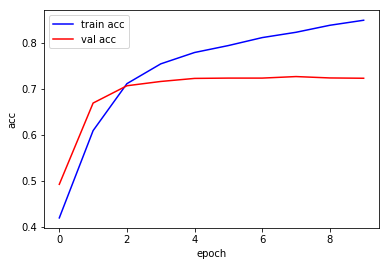

In [28]:
plt.plot(history.epoch,history.history['acc'],c='b',label='train acc')
plt.plot(history.epoch,history.history['val_acc'],c='r',label='val acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2000000   
_________________________________________________________________
dense_1 (Dense)              (None, 200, 50)           5050      
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 30003     
Total params: 2,035,053
Trainable params: 2,035,053
Non-trainable params: 0
_________________________________________________________________


## Make predictions

In [30]:
y_pred = model.predict_classes(test_sequences)#np.argmax(model.predict(test_sequences),axis=1)

3000/3000 [==============================] - 0s     


In [31]:
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predictions'])

Predictions,0,1,2
Actual,,,
0,734,177,89
1,153,659,188
2,54,167,779


## Evaluate the model

In [32]:
model.evaluate(test_sequences,keras.utils.to_categorical(y_test,3), verbose=0)#[loss, accuracy]

[0.6897319092750549, 0.7240000001589457]

## Save and load the model

In [33]:
model.save('model.h5')

In [34]:
model2 = load_model('model.h5')

In [35]:
model2.predict_classes(test_sequences)

3000/3000 [==============================] - 0s     


array([2, 2, 1, ..., 1, 2, 2])